In [3]:
from Backtest import Backtest,Position,Bid
import random
import warnings
#warnings.filterwarnings("ignore")

# Bid Class Demo
## intialize a Bid instance with four variables
- ticker
- shares
- price
- bid_type (1 as buy, 0 as sell)


In [4]:
# a bid to buy 100 shares of Apple at $163.43
buy_apple_100 = Bid(ticker = "AAPL", shares = 100, price = 163.43, bid_type = 1)

#the show method could be used for debugging
buy_apple_100.show()

Buying:
Ticker: AAPL
Shares: 100
Price: 163.43


# 

# Position class demo
## intialize a Position  instance with a bid instance

In [5]:
apple_position = Position(buy_apple_100)
apple_position.show()

Ticker: AAPL
Shares_held: 100
Latest_price: 163.43
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	100


## Change the position with another bid

In [6]:
buy_apple_50 = Bid(ticker = "AAPL", shares = 50, price = 163.13, bid_type = 1)
apple_position.change_position(buy_apple_50)
apple_position.show()

Ticker: AAPL
Shares_held: 150
Latest_price: 163.13
weighted_average_cost: 163.33
----------------
Purchasing History
Price	Shares
163.43	100
163.13	50


## Selling a stock

In [7]:
sell_apple_70 = Bid(ticker = 'AAPL', shares = 70, price = 165.24, bid_type = 0)

#if selling a stock, the change_position method will return a cost
#this cost will be the lowest part of costs in purchasing history 
cost_of_buying_70 = apple_position.change_position(sell_apple_70)
apple_position.show()

Ticker: AAPL
Shares_held: 80
Latest_price: 165.24
weighted_average_cost: 163.43
----------------
Purchasing History
Price	Shares
163.43	80


In [8]:
income = sell_apple_70.shares * sell_apple_70.price
print("Income: ", income)
print("Cost: ", cost_of_buying_70)
print("Pnl for this single trade: ", income - cost_of_buying_70 )

Income:  11566.800000000001
Cost:  11425.1
Pnl for this single trade:  141.70000000000073


# 

# Load sample data

In [9]:
data = pd.read_csv("test_data.csv",index_col=[0])
data.index = pd.to_datetime(data.index)
data.head(5)

,cat,mcd,etsy,twtr,kmi,gme,celg,wdc,ups,nflx,...,ms,abt,jpm,lb,rad,bbby,nvda,biib,aal,vz
2019-04-05 09:30:00,133.561,182.697,68.54,34.6301,17.8967,9.9000,94.2100,49.8244,107.836,369.111,...,42.9067,76.4354,99.8698,26.1864,11.196,17.0190,189.751,236.020,33.7574,54.2369
2019-04-05 09:31:00,133.400,182.908,68.49,34.5500,17.9057,9.8900,94.2500,49.8920,107.873,367.880,...,42.8782,76.4257,99.9170,26.2429,11.168,16.8594,189.492,235.786,33.8956,54.1446
2019-04-05 09:32:00,133.726,182.678,68.59,34.5170,17.9282,9.9000,94.3162,49.9269,108.143,367.810,...,43.0824,76.2125,100.1200,26.2476,11.060,16.8125,189.553,236.353,33.8956,54.1597
2019-04-05 09:33:00,133.554,182.448,68.51,34.5000,17.8966,9.9900,94.3700,50.1188,107.940,367.539,...,42.9162,76.0866,99.7659,26.2523,11.020,16.8219,189.144,236.300,33.8614,54.2921
2019-04-05 09:34:00,133.058,182.533,68.50,34.6700,17.8743,9.9501,94.3600,50.1332,107.874,368.050,...,42.9162,75.9897,99.8131,26.2900,11.018,16.6811,189.518,236.010,33.7678,54.2369


# A demo strategy
## Randomly buy 10 stocks at 9:30 everyday and sell at 16:00
## a strategy function has four parameters, which are:
- ti: current datetime 
- df: all historical data up to ti
- positions: a dictionary of all current positions (k: string of ticker, v: an instance of this ticker's Position)
- cash: cash avaliable

## and it should return a list of Bid instances

In [10]:
def my_strategy(ti,df,positions,cash):
    
    if ti.minute == 0 or ti.minute == 30:
        print("================={}=================".format(ti))
    bid_list = []
    
    #buy
    if ti.hour == 9 and ti.minute == 30:
        for i in range(10):
            ticker = random.choice(df.columns)
            
            #latest price
            price = df.iloc[-1][ticker]
            
            bid = Bid(ticker = ticker, shares = 100, price = price,bid_type = 1)
            bid_list.append(bid)
            bid.show()
        return bid_list
    
    #sell
    if ti.hour == 16 and ti.minute == 0:
        #for all current positions
        for pos in positions.values():
            #ticker
            ticker = pos.ticker
            #latest price
            price = price = df.iloc[-1][pos.ticker]
            #shares held in current position
            shares_held = pos.shares
            
            bid = Bid(ticker = ticker,shares = shares_held,price = price,bid_type = 0)
            bid_list.append(bid)
            bid.show()
        return bid_list
    return bid_list

# Backtest Demo
## initialize a Backtest instance with data and strategy, in default:
- initial_amount = 100000
- has_tc = True (0.2% of transaction cost)

In [11]:
random_strat = Backtest(data.dropna(axis = 0),my_strategy)

In [12]:
random_strat.backtest_full()

=================2019-04-05 09:30:00=================
Buying:
Ticker: hpe
Shares: 100
Price: 15.0319
Buying:
Ticker: f
Shares: 100
Price: 8.6175
Buying:
Ticker: nvda
Shares: 100
Price: 189.751
Buying:
Ticker: aapl
Shares: 100
Price: 48.2024
Buying:
Ticker: ctl
Shares: 100
Price: 10.9352
Buying:
Ticker: wfc
Shares: 100
Price: 45.9037
Buying:
Ticker: pm
Shares: 100
Price: 77.1198
Buying:
Ticker: stx
Shares: 100
Price: 45.2943
Buying:
Ticker: aal
Shares: 100
Price: 33.7574
Buying:
Ticker: fisv
Shares: 100
Price: 90.4975
=================2019-04-05 10:00:00=================
=================2019-04-05 10:30:00=================
=================2019-04-05 11:00:00=================
=================2019-04-05 11:30:00=================
=================2019-04-05 12:00:00=================
=================2019-04-05 12:30:00=================
=================2019-04-05 13:00:00=================
=================2019-04-05 13:30:00=================
=================2019-04-05 14:00:00=========

=================2019-04-17 10:00:00=================
=================2019-04-17 10:30:00=================
=================2019-04-17 11:00:00=================
=================2019-04-17 11:30:00=================
=================2019-04-17 12:00:00=================
=================2019-04-17 12:30:00=================
=================2019-04-17 13:00:00=================
=================2019-04-17 13:30:00=================
=================2019-04-17 14:00:00=================
=================2019-04-17 14:30:00=================
=================2019-04-17 15:00:00=================
=================2019-04-17 15:30:00=================
=================2019-04-17 16:00:00=================
Selling
Ticker: intc
Shares: 100
Price: 56.1019
Selling
Ticker: cnc
Shares: 100
Price: 46.99
Selling
Ticker: ups
Shares: 100
Price: 107.968
Selling
Ticker: ual
Shares: 100
Price: 89.24
Selling
Ticker: fdx
Shares: 100
Price: 192.783
Selling
Ticker: unh
Shares: 100
Price: 210.582
Selling
Ticker: cvs

=================2019-04-18 10:00:00=================
=================2019-04-18 10:30:00=================
=================2019-04-18 11:00:00=================
=================2019-04-18 11:30:00=================
=================2019-04-18 12:00:00=================
=================2019-04-18 12:30:00=================
=================2019-04-18 13:00:00=================
=================2019-04-18 13:30:00=================
=================2019-04-18 14:00:00=================
=================2019-04-18 14:30:00=================
=================2019-04-18 15:00:00=================
=================2019-04-18 15:30:00=================
=================2019-04-18 16:00:00=================
Selling
Ticker: dal
Shares: 100
Price: 56.6372
Selling
Ticker: odp
Shares: 100
Price: 23.2833
Selling
Ticker: utx
Shares: 100
Price: 134.133
Selling
Ticker: amat
Shares: 100
Price: 42.8023
Selling
Ticker: ma
Shares: 100
Price: 238.676
Selling
Ticker: ge
Shares: 100
Price: 9.2655
Selling
Ticker: ib

=================2019-04-22 11:00:00=================
=================2019-04-22 11:30:00=================
=================2019-04-22 12:00:00=================
=================2019-04-22 12:30:00=================
=================2019-04-22 13:00:00=================
=================2019-04-22 13:30:00=================
=================2019-04-22 14:00:00=================
=================2019-04-22 14:30:00=================
=================2019-04-22 15:00:00=================
=================2019-04-22 15:30:00=================
=================2019-04-22 16:00:00=================
Selling
Ticker: tmus
Shares: 100
Price: 73.72
Selling
Ticker: nke
Shares: 100
Price: 85.829
Selling
Ticker: antm
Shares: 100
Price: 238.536
Selling
Ticker: wft
Shares: 100
Price: 0.61
Selling
Ticker: hal
Shares: 100
Price: 29.6818
Selling
Ticker: intu
Shares: 100
Price: 258.226
Selling
Ticker: fcx
Shares: 100
Price: 13.4627
Selling
Ticker: cnc
Shares: 100
Price: 48.11
Selling
Ticker: odp
Shares: 100
Pri

Not enough cash to build a position for mpc
Not enough cash to build a position for fb
Not enough cash to build a position for abt
=================2019-04-23 10:00:00=================
=================2019-04-23 10:30:00=================
=================2019-04-23 11:00:00=================
=================2019-04-23 11:30:00=================
=================2019-04-23 12:00:00=================
=================2019-04-23 12:30:00=================
=================2019-04-23 13:00:00=================
=================2019-04-23 13:30:00=================
=================2019-04-23 14:00:00=================
=================2019-04-23 14:30:00=================
=================2019-04-23 15:00:00=================
=================2019-04-23 15:30:00=================
=================2019-04-23 16:00:00=================
Selling
Ticker: rig
Shares: 100
Price: 9.65
Selling
Ticker: tmus
Shares: 100
Price: 73.75
Selling
Ticker: lmt
Shares: 100
Price: 318.757
Selling
Ticker: intc
Shares: 1

# After backtest, check all historical transactions with transaction_history, a dataframe that recorded each bid, its transaction cost and pnl.

In [13]:
random_strat.transaction_history

,dt,ticker,type,price,shares,amount,cash_left,transaction_cost,pnl
0,2019-04-05 09:30:00,hpe,1,15.0319,100,1503.19,98493.80362,3.00638,0.00
1,2019-04-05 09:30:00,f,1,8.6175,100,861.75,97630.33012,1.72350,0.00
2,2019-04-05 09:30:00,nvda,1,189.7510,100,18975.10,78617.27992,37.95020,0.00
3,2019-04-05 09:30:00,aapl,1,48.2024,100,4820.24,73787.39944,9.64048,0.00
4,2019-04-05 09:30:00,ctl,1,10.9352,100,1093.52,72691.69240,2.18704,0.00
...,...,...,...,...,...,...,...,...,...
360,2019-04-23 16:00:00,lmt,0,318.7570,100,31875.70,44711.51826,63.75140,716.10
361,2019-04-23 16:00:00,intc,0,56.3319,100,5633.19,50333.44188,11.26638,10.58
362,2019-04-23 16:00:00,ilmn,0,322.0590,100,32205.90,82474.93008,64.41180,740.90
363,2019-04-23 16:00:00,cvx,0,112.0390,100,11203.90,93656.42228,22.40780,18.40


In [14]:
print("Total Transaction cost:", random_strat.transaction_history['transaction_cost'].sum())

Total Transaction cost: 6893.36542


<AxesSubplot:>

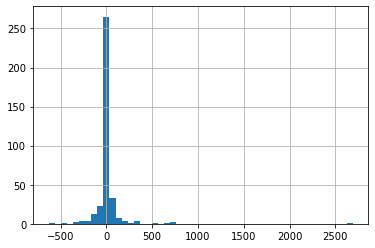

In [15]:
#histogram of pnl
random_strat.transaction_history['pnl'].hist(bins = 50)

# The portfolio_tracker records the # of bids, length of positions,cash value, position value, total value at each ti. 
# The bah column is the value assuming we buy all the tickers when it begins

In [16]:
random_strat.portfolio_tracker

,dt,bid_count,position_count,cash_value,positions_value,total_value,bah
0,2019-04-05 09:30:00,10,10,43375.90786,56511.07,99886.97786,99856.000000
1,2019-04-05 09:31:00,0,10,43375.90786,56486.17,99862.07786,99866.790832
2,2019-04-05 09:32:00,0,10,43375.90786,56493.20,99869.10786,99926.823833
3,2019-04-05 09:33:00,0,10,43375.90786,56428.20,99804.10786,99827.385857
4,2019-04-05 09:34:00,0,10,43375.90786,56454.33,99830.23786,99788.805765
...,...,...,...,...,...,...,...
8836,2019-04-23 16:26:00,0,0,96754.06458,0.00,96754.06458,100606.956988
8837,2019-04-23 16:27:00,0,0,96754.06458,0.00,96754.06458,100578.631615
8838,2019-04-23 16:28:00,0,0,96754.06458,0.00,96754.06458,100571.295174
8839,2019-04-23 16:29:00,0,0,96754.06458,0.00,96754.06458,100562.975929


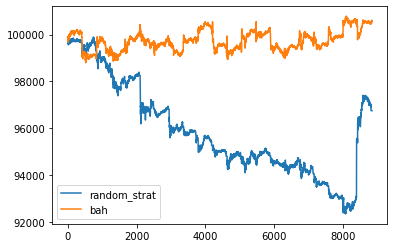

In [17]:
plt.plot(random_strat.portfolio_tracker['total_value'], label = 'random_strat')
plt.plot(random_strat.portfolio_tracker['bah'],label = 'bah')
plt.legend()

# 

# Upload to dashboard
## the upload_to_dashboard method will upload this graph to dashboard.
## make sure the crediential file "algo-trade-dashboard-80cae071e907.json" is under current directory, also install the related packages in requirements.txt

## to upload, call the function with the strategy name, if the name already exist in the gcloud, the previous data will be overwritten

In [18]:
random_strat.upload_to_dashboard("random_demo_0912")

Data uploaded.


# Check on dashboard:
https://tigaji-algo-trade-dashboard-dashboard-gv8r0a.streamlitapp.com/